*Name*: `Venkata Skandha Rajendra Varma`

*Student No*: `GH1036345`

*Sunject*: `Big Data Analytics - M508B`

**Business Objective**

As a leading news provider like CNN, our goal is to adapt to changing user behavior by offering quick, digestible news content through a mobile app. With users having less time to read full articles, we aim to increase engagement and retention by delivering short, high-quality news snippets. To support this, we are building an NLP-based summarization system that converts long news articles into concise summaries without losing core information or tone.

**Problem Statement**

Today’s users often lack the time to read lengthy news articles, leading to reduced engagement and incomplete understanding of current events. Traditional news formats are not optimized for mobile, on-the-go consumption. To solve this, we propose an NLP-driven solution that summarizes full-length news into short, coherent snippets for mobile display. The challenge is to ensure that these summaries are accurate, grammatically sound, and informative while maintaining the integrity of the original content.

In [6]:
import os
os.getcwd()


'C:\\Users\\skand\\Documents\\Gisma Subjects\\2nd Semeseter 1 Quater\\NLP\\Final NLP Project\\archive\\cnn_dailymail'

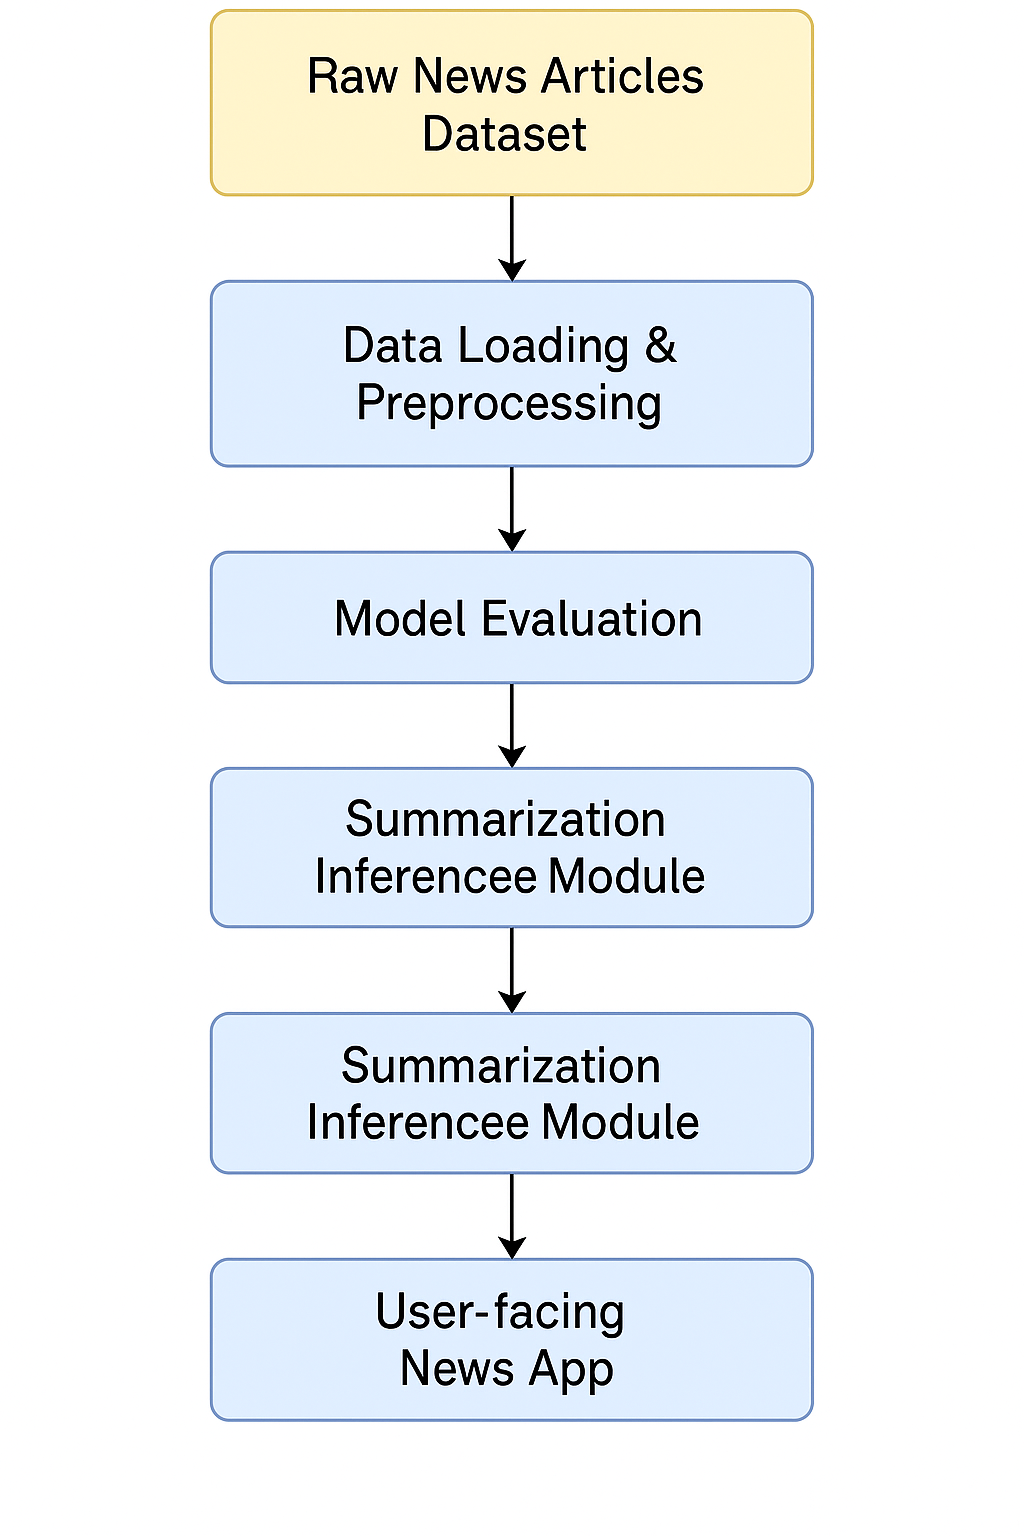

In [9]:
from IPython.display import Image
# Image(filename='C:\Users\skand\Documents\Gisma Subjects\2nd Semeseter 1 Quater\NLP\Final NLP Project\archive\cnn_dailymail/SYStem Design.png')
Image(filename=r'C:\Users\skand\Documents\Gisma Subjects\2nd Semeseter 1 Quater\NLP\Final NLP Project\archive\cnn_dailymail\SYStem Design.png')



***IMPORTING DEPENDENCIES***

In [2]:
import pandas as pd
from datasets import Dataset
from transformers import BartTokenizer

***LOADING DATA***

Kaggle Dataset: https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail

Here the data is already split into TEST, TRAIN and VALIDATION sets. 

In [13]:
# Load CSV files
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")

In [4]:
print(train_df.columns)
print(val_df.columns)
print(test_df.columns)

Index(['id', 'article', 'highlights'], dtype='object')
Index(['id', 'article', 'highlights'], dtype='object')
Index(['id', 'article', 'highlights'], dtype='object')


**Here we are scaling dow the dataset to make it more manageable for testing purposes.**

In [5]:
train_df_small = train_df.sample(n=1000, random_state=42).reset_index(drop=True)
val_df_small = val_df.sample(n=125, random_state=42).reset_index(drop=True)
test_df_small = test_df.sample(n=125, random_state=42).reset_index(drop=True)


We are renaming the columns to make them more intuitive for our summarization task. The 'article' column will contain the full text of the news article, and the 'highlights' column will contain the summary of that article.

In [6]:
train_df_small = train_df_small.rename(columns={'article': 'input_text', 'highlights': 'summary'})
val_df_small = val_df_small.rename(columns={'article': 'input_text', 'highlights': 'summary'})
test_df_small = test_df_small.rename(columns={'article': 'input_text', 'highlights': 'summary'})

In these lines, we are converting the smaller versions of our pandas DataFrames (`train_df_small`, `val_df_small`, and `test_df_small`) into Hugging Face `Dataset` objects. This format is optimized for use with the Hugging Face Transformers library and enables efficient preprocessing, tokenization, and integration with model training pipelines.


In [7]:
# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df_small)
val_dataset = Dataset.from_pandas(val_df_small)
test_dataset = Dataset.from_pandas(test_df_small)

We are loading the pretrained BART tokenizer from the 'facebook/bart-base' model. The tokenizer is responsible for converting raw text into token IDs that the BART model can understand, ensuring the input format matches what the model was trained on.

*Why We Use BART for Summarization*
We use BART (facebook/bart-base) because it is specifically designed for abstractive summarization, meaning it can generate short, rephrased versions of longer texts — ideal for news snippets.

Key Advantages:

- Pretrained for Summarization: Fine-tuned on datasets like CNN/DailyMail.

- Encoder-Decoder Architecture: Combines understanding (like BERT) and generation (like GPT).

- High Accuracy: Produces fluent, human-like summaries.

In [8]:
# Load tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

In the next step we have created a function called `process_data()`.

This function tokenizes the input articles and their summaries for the BART model. It truncates and pads the inputs to fixed lengths (1024 for articles, 128 for summaries) and prepares the summaries as labels for training. This formats the data correctly for the model to learn from.


In [9]:
# Tokenization function
def preprocess_data(examples):
    model_inputs = tokenizer(examples["input_text"], max_length=1024, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [10]:
print(train_dataset.column_names)


['id', 'input_text', 'summary']


These lines apply the `preprocess_data` function to the entire training, validation, and test datasets using the Hugging Face `map` method. This tokenizes all examples in batches, preparing the datasets in the correct format for model training and evaluation.


In [11]:
# Tokenize datasets
tokenized_train = train_dataset.map(preprocess_data, batched=True)
tokenized_val = val_dataset.map(preprocess_data, batched=True)
tokenized_test = test_dataset.map(preprocess_data, batched=True)

# Model & Trainer code remains unchanged


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 125/125 [00:00<00:00, 189.27 examples/s]


This code below loads the pretrained BART model and sets up `training parameters like batch size, epochs,` and `logging`. It then initializes a Hugging Face `Trainer` with the model, tokenized datasets, and tokenizer, and starts fine-tuning the model on the training data.


In [12]:
import transformers
from transformers import BartForConditionalGeneration, TrainingArguments, Trainer

model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=2,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    fp16=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
)

trainer.train()


C:\Users\skand\AppData\Local\Temp\ipykernel_28644\1697805978.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,7.301800
20,5.810800
30,4.296600
40,3.646200
50,2.866000
60,2.473300
70,2.153900
80,1.858600
90,1.569900
100,1.373800


c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:3685: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1000, training_loss=1.3467417368888854, metrics={'train_runtime': 4892.6974, 'train_samples_per_second': 0.409, 'train_steps_per_second': 0.204, 'total_flos': 1219472916480000.0, 'train_loss': 1.3467417368888854, 'epoch': 2.0})

We load the **ROUGE** metric to evaluate summarization quality. The `compute_metrics` function decodes model predictions and true summaries, then calculates ROUGE scores (measuring overlap between them). Finally, the `trainer.evaluate()` call runs evaluation on the test dataset using these metrics to assess model performance.


In [14]:
import evaluate

# Load the ROUGE metric using the new evaluate library
rouge = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute ROUGE scores
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # Convert result to a simpler format
    return {key: value.mid.fmeasure * 100 for key, value in result.items()}

# Evaluate on the test set using a Hugging Face Trainer
trainer.evaluate(eval_dataset=tokenized_test, metric_key_prefix="test")


c:\Users\skand\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'test_loss': 1.1153616905212402,
 'test_runtime': 39.487,
 'test_samples_per_second': 3.166,
 'test_steps_per_second': 1.595,
 'epoch': 2.0}


At last we have loaded fine-tuned BART model and tokenizer from your local checkpoint, sets the model to evaluation mode, then generates and prints summaries for the first 5 test articles. For each article, it tokenizes the input, generates a summary with beam search, decodes the summary back to text, and compares it to the actual reference summary. This helps you see how well the model summarizes real examples.


In [15]:
from transformers import BartForConditionalGeneration, BartTokenizer

# Load model and tokenizer (if not already loaded)
model = BartForConditionalGeneration.from_pretrained('C:\\Users\\skand\\Documents\\Gisma Subjects\\2nd Semeseter 1 Quater\\NLP\\Final NLP Project\\archive\\cnn_dailymail\\results\\checkpoint-1000')  # or 'facebook/bart-base' if base model
tokenizer = BartTokenizer.from_pretrained('C:\\Users\\skand\\Documents\\Gisma Subjects\\2nd Semeseter 1 Quater\\NLP\\Final NLP Project\\archive\\cnn_dailymail\\results\\checkpoint-1000')

# Put model in eval mode
model.eval()

for i in range(5):
    input_text = test_df.iloc[i]['article']  # original article
    actual_summary = test_df.iloc[i]['highlights']  # actual summary

    # Tokenize input
    inputs = tokenizer([input_text], max_length=1024, truncation=True, return_tensors='pt')

    # Generate summary (adjust parameters if needed)
    summary_ids = model.generate(
        inputs['input_ids'], 
        num_beams=4, 
        max_length=128, 
        early_stopping=True
    )
    
    # Decode generated summary
    predicted_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    print(f"---- Example {i+1} ----")
    print(f"Original Article:\n{input_text[:300]}...")  # print first 300 chars for brevity
    print(f"Actual Summary:\n{actual_summary}")
    print(f"Predicted Summary:\n{predicted_summary}")
    print("\n")


---- Example 1 ----
Original Article:
Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. They say that the shrinking space on aeroplanes is not only uncomfortable - it's ...
Actual Summary:
Experts question if  packed out planes are putting passengers at risk .
U.S consumer advisory group says minimum space must be stipulated .
Safety tests conducted on planes with more leg room than airlines offer .
Predicted Summary:
U.S. consumer advisory group set up to set standards for animals flying on planes is questioning if having such packed out planes is putting passengers at risk .
They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger .


---- Example 2 ----
Original Article:
A drunk teenage boy had to be rescued by security after jumping into a lions' enclos